# 함수 선언 및  import

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib


import sklearn
import xgboost
from xgboost import XGBRegressor


from sklearn.model_selection import KFold

import random as rn

RANDOM_SEED = 2024
np.random.seed(RANDOM_SEED)
rn.seed(RANDOM_SEED)



from datetime import datetime

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
def smape(gt, preds):
    gt= np.array(gt)
    preds = np.array(preds)
    v = 2 * abs(preds - gt) / (abs(preds) + abs(gt))
    score = np.mean(v) * 100
    return score

In [3]:
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

In [4]:
def custom_smape(preds, dtrain):
    labels = dtrain.get_label()
    return 'custom_smape', np.mean(2 * abs(preds - labels) / (abs(preds) + abs(labels))) * 100

# 데이터 전처리

## 데이터 불러오기

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
building_info = pd.read_csv('building_info.csv')

In [6]:
train = train.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
train.drop('num_date_time', axis = 1, inplace=True)

test = test.rename(columns={
    '건물번호': 'building_number',
    '일시': 'date_time',
    '기온(°C)': 'temperature',
    '강수량(mm)': 'rainfall',
    '풍속(m/s)': 'windspeed',
    '습도(%)': 'humidity',
    '일조(hr)': 'sunshine',
    '일사(MJ/m2)': 'solar_radiation',
    '전력소비량(kWh)': 'power_consumption'
})
test.drop('num_date_time', axis = 1, inplace=True)

In [7]:
building_info = building_info.rename(columns={
    '건물번호': 'building_number',
    '건물유형': 'building_type',
    '연면적(m2)': 'total_area',
    '냉방면적(m2)': 'cooling_area',
    '태양광용량(kW)': 'solar_power_capacity',
    'ESS저장용량(kWh)': 'ess_capacity',
    'PCS용량(kW)': 'pcs_capacity'
})

In [8]:
translation_dict = {
    '건물기타': 'Other Buildings',
    '공공': 'Public',
    '대학교': 'University',
    '데이터센터': 'Data Center',
    '백화점및아울렛': 'Department Store and Outlet',
    '병원': 'Hospital',
    '상용': 'Commercial',
    '아파트': 'Apartment',
    '연구소': 'Research Institute',
    '지식산업센터': 'Knowledge Industry Center',
    '할인마트': 'Discount Mart',
    '호텔및리조트': 'Hotel and Resort'
}

building_info['building_type'] = building_info['building_type'].replace(translation_dict)

In [9]:
building_info['solar_power_utility'] = np.where(building_info.solar_power_capacity !='-',1,0)
building_info['ess_utility'] = np.where(building_info.ess_capacity !='-',1,0)

In [10]:
train = pd.merge(train, building_info, on='building_number', how='left')
test = pd.merge(test, building_info, on='building_number', how='left')

# 🔹 여기서 냉방면적비 추가
train["cooling_ratio"] = (
    train["cooling_area"] / train["total_area"]
).replace([np.inf, -np.inf], np.nan).fillna(0)

test["cooling_ratio"] = (
    test["cooling_area"] / test["total_area"]
).replace([np.inf, -np.inf], np.nan).fillna(0)

## 결측치 확인 및 보간

In [11]:
train.isna().sum()

,0
building_number,0
date_time,0
temperature,0
rainfall,0
windspeed,0
humidity,0
sunshine,0
solar_radiation,0
power_consumption,0
building_type,0


In [12]:
train.solar_power_capacity.value_counts()

,count
solar_power_capacity,
-,95880
278.58,2040
1983.05,2040
389.76,2040
217.92,2040
1349.03,2040
276,2040
849.78,2040
1974.71,2040


In [13]:
train.ess_capacity.value_counts()

,count
ess_capacity,
-,179520
2000,4080
101.5,2040
1025,2040
500,2040
3100,2040
205,2040
469.2,2040
1670,2040


In [14]:
train.pcs_capacity.value_counts()

,count
pcs_capacity,
-,179520
101,4080
1000,4080
500,4080
250,2040
1500,2040
150,2040
550,2040
75,2040


In [15]:
train['windspeed']= train.windspeed.interpolate()
train['humidity']= train.humidity.interpolate()

## Datetime 분리

In [16]:
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y%m%d %H')

# date time feature 생성
train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.day
train['month'] = train['date_time'].dt.month
train['day_of_week'] = train['date_time'].dt.dayofweek #요일


test['date_time'] = pd.to_datetime(test['date_time'], format='%Y%m%d %H')

# date time feature 생성
test['hour'] = test['date_time'].dt.hour
test['day'] = test['date_time'].dt.day
test['month'] = test['date_time'].dt.month
test['day_of_week'] = test['date_time'].dt.dayofweek #요일

## Feature Engineering

### 평균기온, 최대기온 변수

In [17]:
def calculate_day_values(dataframe, target_column, output_column, aggregation_func):
    result_dict = {}

    grouped_temp = dataframe.groupby(['building_number', 'month', 'day'])[target_column].agg(aggregation_func)

    for (building, month, day), value in grouped_temp.items():
        result_dict.setdefault(building, {}).setdefault(month, {})[day] = value

    dataframe[output_column] = [
        result_dict.get(row['building_number'], {}).get(row['month'], {}).get(row['day'], None)
        for _, row in dataframe.iterrows()
    ]


train['day_max_temperature'] = 0.0
train['day_mean_temperature'] = 0.0

calculate_day_values(train, 'temperature', 'day_max_temperature', 'max')
calculate_day_values(train, 'temperature', 'day_mean_temperature', 'mean')
calculate_day_values(train, 'temperature', 'day_min_temperature', 'min')

train['day_temperature_range'] = train['day_max_temperature'] - train['day_min_temperature']

calculate_day_values(test, 'temperature', 'day_max_temperature', 'max')
calculate_day_values(test, 'temperature', 'day_mean_temperature', 'mean')
calculate_day_values(test, 'temperature', 'day_min_temperature', 'min')

test['day_temperature_range'] = test['day_max_temperature'] - test['day_min_temperature']


### Outlier drop

In [18]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL

# =========================================
# 0) 유틸: 안전한 zscore (robust: median/MAD)
# =========================================
def robust_zscore(x):
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med)) + 1e-9
    return (x - med) / (1.4826 * mad)

# =========================================
# 1) 규칙 기반: 연속 0(혹은 거의 0) runs
# =========================================
def detect_consecutive_runs(df, col='power_consumption', run_len=4, thresh=1e-6):
    """
    건물별로 date_time 기준 정렬되어 있다고 가정.
    run_len 시간 이상 연속으로 col <= thresh 인 구간의 '해당 구간 인덱스'를 반환
    """
    bad_idx = []
    for b, bdf in df.groupby('building_number'):
        bdf = bdf.sort_values('date_time')
        mask = (bdf[col] <= thresh).astype(int)
        # 연속 구간 찾기
        # run_id는 연속 구간마다 같은 번호를 갖도록 변환
        changes = mask.diff().fillna(0) != 0
        run_id = changes.cumsum()
        # 각 run_id별 길이 계산 (0인 구간도 포함되므로 mask==1인 구간만 고려)
        runs = bdf.assign(run_id=run_id)
        runs = runs[mask == 1]
        if runs.empty:
            continue
        lengths = runs.groupby('run_id').size()
        long_runs = lengths[lengths >= run_len].index
        out = runs[runs['run_id'].isin(long_runs)].index.tolist()
        bad_idx.extend(out)
    return bad_idx

# =========================================
# 2) STL 분해 → 잔차 계산
# =========================================
def stl_residuals_per_building(df, col='power_consumption', period=24):
    """
    건물별로 시계열을 STL 분해하고 residual을 반환
    period=24 (일주기), 주중/주말까지 강하면 24*7 고려
    """
    residual = pd.Series(index=df.index, dtype=float)
    for b, bdf in df.groupby('building_number'):
        bdf = bdf.sort_values('date_time')
        y = bdf[col].astype(float).values
        # 길이가 period*2 이상이어야 STL 안정적
        if len(y) < period * 2:
            residual.loc[bdf.index] = np.nan
            continue
        try:
            stl = STL(y, period=period, robust=True)
            res = stl.fit()
            resid = y - (res.trend + res.seasonal)
            residual.loc[bdf.index] = resid
        except Exception:
            residual.loc[bdf.index] = np.nan
    return residual

# =========================================
# 3) Hampel 필터 (잔차 대상)
# =========================================
def hampel_outliers(series, window=24, n_sigma=3.0):
    """
    롤링 중앙값/ MAD 기반 Hampel: |x - med| / (1.4826*MAD) > n_sigma 이면 이상치
    window는 계절주기(24) 또는 그 배수 추천
    """
    x = series.astype(float).copy()
    # pandas의 rolling median/MAD
    med = x.rolling(window, center=True, min_periods=window//2).median()
    abs_dev = (x - med).abs()
    mad = abs_dev.rolling(window, center=True, min_periods=window//2).median()
    z = (x - med) / (1.4826 * (mad + 1e-9))
    return series.index[np.abs(z) > n_sigma].tolist()

# =========================================
# 4) 잔차에 robust z-score (간단 ESD 대용)
# =========================================
def residual_zscore_outliers(series, z_thresh=4.0):
    z = robust_zscore(series.values)
    return series.index[np.abs(z) > z_thresh].tolist()


# === (ADD) 완화형: 이벤트성은 살리고 정전/센서 오류만 드롭 ===
RELAX_TYPES = ["Public", "Other Buildings", "호텔", "백화점"]

def build_outlier_list_relaxed(train,
                               value_col='power_consumption',
                               run_len=4,
                               zero_thresh=1e-6,
                               stl_period=24,
                               hampel_window=24,
                               hampel_sigma_relax=5.0,  # 완화 타입
                               hampel_sigma_base=3.0,   # 일반 타입
                               resid_z_relax=7.0,       # 완화 타입
                               resid_z_base=4.0,        # 일반 타입
                               use_weekly=False):
    """
    반환: (drop_idx, extreme_idx)
      - drop_idx: 실제 삭제(정전/센서오류 + (완화 아님 타입의 이벤트성))
      - extreme_idx: 삭제 안 하고 is_extreme=1로 표시(완화 타입의 이벤트성)
    """
    df = train.copy()
    assert 'building_type' in df.columns, "train에 building_type 필요"
    df['date_time'] = pd.to_datetime(df['date_time'])
    df = df.sort_values(['building_type','building_number','date_time'])

    drop_idx, extreme_idx = set(), set()

    # 전체 상위 가드(말도 안되게 큰 값 컷)
    try:
        absurd_hi = np.nanpercentile(df[value_col], 99.9) * 5.0
        if not np.isfinite(absurd_hi): absurd_hi = None
    except Exception:
        absurd_hi = None

    for btype, g in df.groupby('building_type'):
        # 1) 연속 0(run) → 정전/센서오류: 무조건 drop
        o1 = detect_consecutive_runs(g, col=value_col, run_len=run_len, thresh=zero_thresh)

        # 2) STL 잔차 기반 이벤트성 후보
        resid_daily = stl_residuals_per_building(g, col=value_col, period=stl_period)
        if btype in RELAX_TYPES:
            hs, rz = hampel_sigma_relax, resid_z_relax
        else:
            hs, rz = hampel_sigma_base, resid_z_base

        o2 = hampel_outliers(resid_daily, window=hampel_window, n_sigma=hs)
        o3 = residual_zscore_outliers(resid_daily.dropna(), z_thresh=rz)

        if use_weekly:
            resid_week = stl_residuals_per_building(g, col=value_col, period=24*7)
            o4 = hampel_outliers(resid_week, window=24*7, n_sigma=hs)
            o5 = residual_zscore_outliers(resid_week.dropna(), z_thresh=rz)
        else:
            o4, o5 = [], []

        event_like  = set(o2) | set(o3) | set(o4) | set(o5)

        # 3) 센서/정전 직접 규칙(0, 음수, 급락, 황당히 큰 값)
        sub = g[value_col].astype(float)
        outage_mask = (sub <= zero_thresh) | (sub < 0)
        if absurd_hi is not None:
            outage_mask |= (sub > absurd_hi)
        prev = sub.shift(1)
        drop_mask = (prev > 0) & ((prev - sub) / (prev + 1e-9) >= 0.95)
        sensor_like = set(g.index[outage_mask | drop_mask])

        if btype in RELAX_TYPES:
            # 완화 타입: 센서는 drop, 이벤트성은 살려서 플래그
            drop_idx |= sensor_like
            extreme_idx |= (event_like - sensor_like)
        else:
            # 일반 타입: 이벤트성도 drop
            drop_idx |= (sensor_like | event_like)

        # (선택) 과도 제거 방지: 건물별 2%
        for bn, bdf in g.groupby('building_number'):
            b_out = list(set(bdf.index) & drop_idx)
            max_keep = int(0.02 * len(bdf))
            if len(b_out) > max_keep and max_keep > 0:
                keep_back = set(bdf.index) & drop_idx
                # 단순 상한 적용(원하면 |잔차| 기준 정렬해도 됨)
                keep_back = set(list(keep_back)[:max_keep])
                drop_idx -= ((set(bdf.index) & drop_idx) - keep_back)

    return sorted(list(drop_idx)), sorted(list(extreme_idx))


In [19]:
drop_idx, extreme_idx = build_outlier_list_relaxed(
    train,
    value_col='power_consumption',
    run_len=4,
    zero_thresh=1e-6,
    stl_period=24,
    hampel_window=24,
    hampel_sigma_relax=5.0,  # 완화
    hampel_sigma_base=3.0,   # 기본
    resid_z_relax=7.0,       # 완화
    resid_z_base=4.0,        # 기본
    use_weekly=True
)
print(f"삭제(drop): {len(drop_idx)} | 이벤트성 표시(extreme): {len(extreme_idx)}")

# 플래그 추가 + 드롭 적용
train_marked = train.copy()
train_marked["is_extreme"] = 0
train_marked.loc[extreme_idx, "is_extreme"] = 1

train = train_marked.drop(index=drop_idx).reset_index(drop=True)

# 테스트에는 플래그 0으로 생성
if "is_extreme" not in test.columns:
    test["is_extreme"] = 0

삭제(drop): 2255 | 이벤트성 표시(extreme): 18573


### 임시 휴무 추측 데이터 drop

In [20]:
# temp_hol = {2 : ['2022-06-17'],
#     5 : ['2022-07-25','2022-08-02','2022-08-09','2022-08-16'],
#     11 : ['2022-06-17'], 12 : ['2022-07-02'], 17 : ['2022-06-18','2022-07-25'],
#     21 : ['2022-07-01','2022-07-03','2022-07-17','2022-07-30'],
#     37 : ['2022-06-20','2022-07-11','2022-08-08'],
#     38 : ['2022-06-13','2022-07-25','2022-08-01'],
#     39 : ['2022-07-18','2022-08-08'],
#     40 : ['2022-06-20','2022-07-18','2022-08-08'],
#     41 : ['2022-06-27','2022-07-25','2022-08-08'],
#     42 : ['2022-06-13','2022-07-11','2022-08-22'],
#     54 : ['2022-08-16','2022-08-17'],74 : ['2022-06-03'],
#     75 : ['2022-06-15','2022-06-17','2022-06-20','2022-06-21'],
#     86 : ['2022-06-10','2022-08-10'],
#     89 : ['2022-07-09'], 91 : ['2022-06-13','2022-07-11','2022-08-22','2022-06-08'], 92 : ['2022-07-30']}


# mask = train.apply(lambda x: x['building_number'] in temp_hol and str(x['date_time'])[:10] in temp_hol[x['building_number']], axis=1)

# train.drop(train[mask].index, axis=0, inplace=True)

# train.reset_index(drop=True, inplace=True)

### 공휴일변수

In [21]:
holi_weekday = [
    '2024-06-06',  # 현충일 (목)
    '2024-08-15'   # 광복절 (목)
]

train['holiday'] = np.where((train.day_of_week >= 5) | (train.date_time.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)
test['holiday'] = np.where((test.day_of_week >= 5) | (test.date_time.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)

### 대형마트 휴무일요일 변수

In [22]:
holi_sun = [
    '2024-06-09', '2024-06-23',  # 6월
    '2024-07-14', '2024-07-28',  # 7월
    '2024-08-11', '2024-08-25'   # 8월
]

# 의무 휴업 일요일이면 1, 아니면 0
train['Sunday_holiday'] = np.where((train.day_of_week == 6) & (train.date_time.dt.strftime('%Y-%m-%d').isin(holi_sun)), 1, 0)
test['Sunday_holiday'] = np.where((test.day_of_week == 6) & (test.date_time.dt.strftime('%Y-%m-%d').isin(holi_sun)), 1, 0)

### 시간변수 푸리에변환

In [23]:
#시간
train['sin_hour'] = np.sin(2 * np.pi * train['hour']/23.0)
train['cos_hour'] = np.cos(2 * np.pi * train['hour']/23.0)
test['sin_hour'] = np.sin(2 * np.pi * test['hour']/23.0)
test['cos_hour'] = np.cos(2 * np.pi * test['hour']/23.0)

#날짜
train['sin_date'] = -np.sin(2 * np.pi * (train['month']+train['day']/31)/12)
train['cos_date'] = -np.cos(2 * np.pi * (train['month']+train['day']/31)/12)
test['sin_date'] = -np.sin(2 * np.pi * (test['month']+test['day']/31)/12)
test['cos_date'] = -np.cos(2 * np.pi * (test['month']+test['day']/31)/12)

#월
train['sin_month'] = -np.sin(2 * np.pi * train['month']/12.0)
train['cos_month'] = -np.cos(2 * np.pi * train['month']/12.0)
test['sin_month'] = -np.sin(2 * np.pi * test['month']/12.0)
test['cos_month'] = -np.cos(2 * np.pi * test['month']/12.0)

#요일
train['sin_dayofweek'] = -np.sin(2 * np.pi * (train['day_of_week']+1)/7.0)
train['cos_dayofweek'] = -np.cos(2 * np.pi * (train['day_of_week']+1)/7.0)
test['sin_dayofweek'] = -np.sin(2 * np.pi * (test['day_of_week']+1)/7.0)
test['cos_dayofweek'] = -np.cos(2 * np.pi * (test['day_of_week']+1)/7.0)

### CDH(냉방도시) 변수

In [24]:
def CDH(xs):
    cumsum = np.cumsum(xs - 26)
    return np.concatenate((cumsum[:11], cumsum[11:] - cumsum[:-11]))

def calculate_and_add_cdh(dataframe):
    cdhs = []
    for i in range(1, 101):
        temp = dataframe[dataframe['building_number'] == i]['temperature'].values
        cdh = CDH(temp)
        cdhs.append(cdh)
    return np.concatenate(cdhs)

train['CDH'] = calculate_and_add_cdh(train)
test['CDH'] = calculate_and_add_cdh(test)

### THI(불쾌지수) 변수

In [25]:
train['THI'] = 9/5*train['temperature'] - 0.55*(1-train['humidity']/100)*(9/5*train['humidity']-26)+32

test['THI'] = 9/5*test['temperature'] - 0.55*(1-test['humidity']/100)*(9/5*test['humidity']-26)+32

### WCT(체감온도) 변수

In [26]:
train['WCT'] = 13.12 + 0.6125*train['temperature'] - 11.37*(train['windspeed']**
                                                            0.16) + 0.3965*(train['windspeed']**0.16)*train['temperature']
test['WCT'] = 13.12 + 0.6125*test['temperature'] - 11.37*(test['windspeed']**
                                                            0.16) + 0.3965*(test['windspeed']**0.16)*test['temperature']

### 전력소비 통계량 변수

In [27]:
# Calculate 'day_hour_mean'
power_mean = pd.pivot_table(train, values='power_consumption', index=['building_number', 'hour', 'day_of_week'], aggfunc=np.mean).reset_index()
power_mean.columns = ['building_number', 'hour', 'day_of_week', 'day_hour_mean']

# Calculate 'day_hour_std'
power_std = pd.pivot_table(train, values='power_consumption', index=['building_number', 'hour', 'day_of_week'], aggfunc=np.std).reset_index()
power_std.columns = ['building_number', 'hour', 'day_of_week', 'day_hour_std']

# Calculate 'hour_mean'
power_hour_mean = pd.pivot_table(train, values='power_consumption', index=['building_number', 'hour'], aggfunc=np.mean).reset_index()
power_hour_mean.columns = ['building_number', 'hour', 'hour_mean']

# Calculate 'hour_std'
power_hour_std = pd.pivot_table(train, values='power_consumption', index=['building_number', 'hour'], aggfunc=np.std).reset_index()
power_hour_std.columns = ['building_number', 'hour', 'hour_std']

# Merge calculated features to 'train' and 'test' dataframes
train = train.merge(power_mean, on=['building_number', 'hour', 'day_of_week'], how='left')
test = test.merge(power_mean, on=['building_number', 'hour', 'day_of_week'], how='left')

train = train.merge(power_std, on=['building_number', 'hour', 'day_of_week'], how='left')
test = test.merge(power_std, on=['building_number', 'hour', 'day_of_week'], how='left')

train = train.merge(power_hour_mean, on=['building_number', 'hour'], how='left')
test = test.merge(power_hour_mean, on=['building_number', 'hour'], how='left')

train = train.merge(power_hour_std, on=['building_number', 'hour'], how='left')
test = test.merge(power_hour_std, on=['building_number', 'hour'], how='left')

train = train.reset_index(drop=True)

# 모델링

## X,Y,test 선언

In [28]:
X = train.drop(['solar_power_capacity', 'ess_capacity', 'pcs_capacity',
                'power_consumption','rainfall', 'sunshine', 'solar_radiation',
                'hour','day','month','day_of_week','date_time'],axis =1 )

Y = train[['building_type','power_consumption']]

test_X = test.drop(['solar_power_capacity', 'ess_capacity', 'pcs_capacity','rainfall',
                   'hour','month','day_of_week','day','date_time'], axis=1)

In [29]:
type_list = []
for value in train.building_type.values:
    if value not in type_list:
        type_list.append(value)

## XGB 건물 유형별 단일모델

In [30]:
xgb_best_params = pd.read_csv('xgb_best_params_found.csv')
xgb_best_params['building_type'] = type_list
xgb_best_params.set_index('building_type',inplace=True)

In [31]:
xgb_best_params

,Unnamed: 0,max_bin,eta,max_depth,min_child_weight,subsample,colsample_bytree,reg_lambda,reg_alpha,alpha
building_type,,,,,,,,,,
호텔,호텔,299,0.171359,4,4,0.704673,0.880432,5.822530e-06,2.698564e-06,1.329574
Commercial,Commercial,383,0.141605,9,12,0.810131,0.983139,4.324914e-01,2.013676e-04,0.661304
Hospital,Hospital,337,0.141396,5,2,0.898258,0.988039,9.927880e-08,4.867693e-04,1.026727
학교,학교,208,0.010676,4,8,0.726598,0.931666,1.910671e-01,8.421429e+00,1.788165
Other Buildings,Other Buildings,259,0.196236,3,1,0.714305,0.792578,1.561624e-03,2.851216e-02,0.763867
Apartment,Apartment,262,0.100000,6,2,0.800000,0.800000,1.000000e+00,1.000000e-08,1.000000
Research Institute,Research Institute,361,0.124921,6,9,0.607584,0.946348,1.568387e-02,7.455931e-03,1.175714
백화점,백화점,301,0.149205,4,6,0.713816,0.991798,1.849544e-05,6.786033e-03,0.952556
IDC(전화국),IDC(전화국),272,0.023924,8,3,0.705876,0.650179,5.562524e-03,1.268305e-01,1.519085


In [32]:
#!pip install xgboost==1.7.6

전체 훈련 데이터 크기: (201745, 140)
전체 테스트 데이터 크기: (16800, 140)

=== Fold 1/7 ===
Fold 1 SMAPE: 3.5381

=== Fold 2/7 ===
Fold 2 SMAPE: 3.5014

=== Fold 3/7 ===
Fold 3 SMAPE: 3.5577

=== Fold 4/7 ===
Fold 4 SMAPE: 3.5495

=== Fold 5/7 ===
Fold 5 SMAPE: 3.4935

=== Fold 6/7 ===
Fold 6 SMAPE: 3.5169

=== Fold 7/7 ===
Fold 7 SMAPE: 3.5327


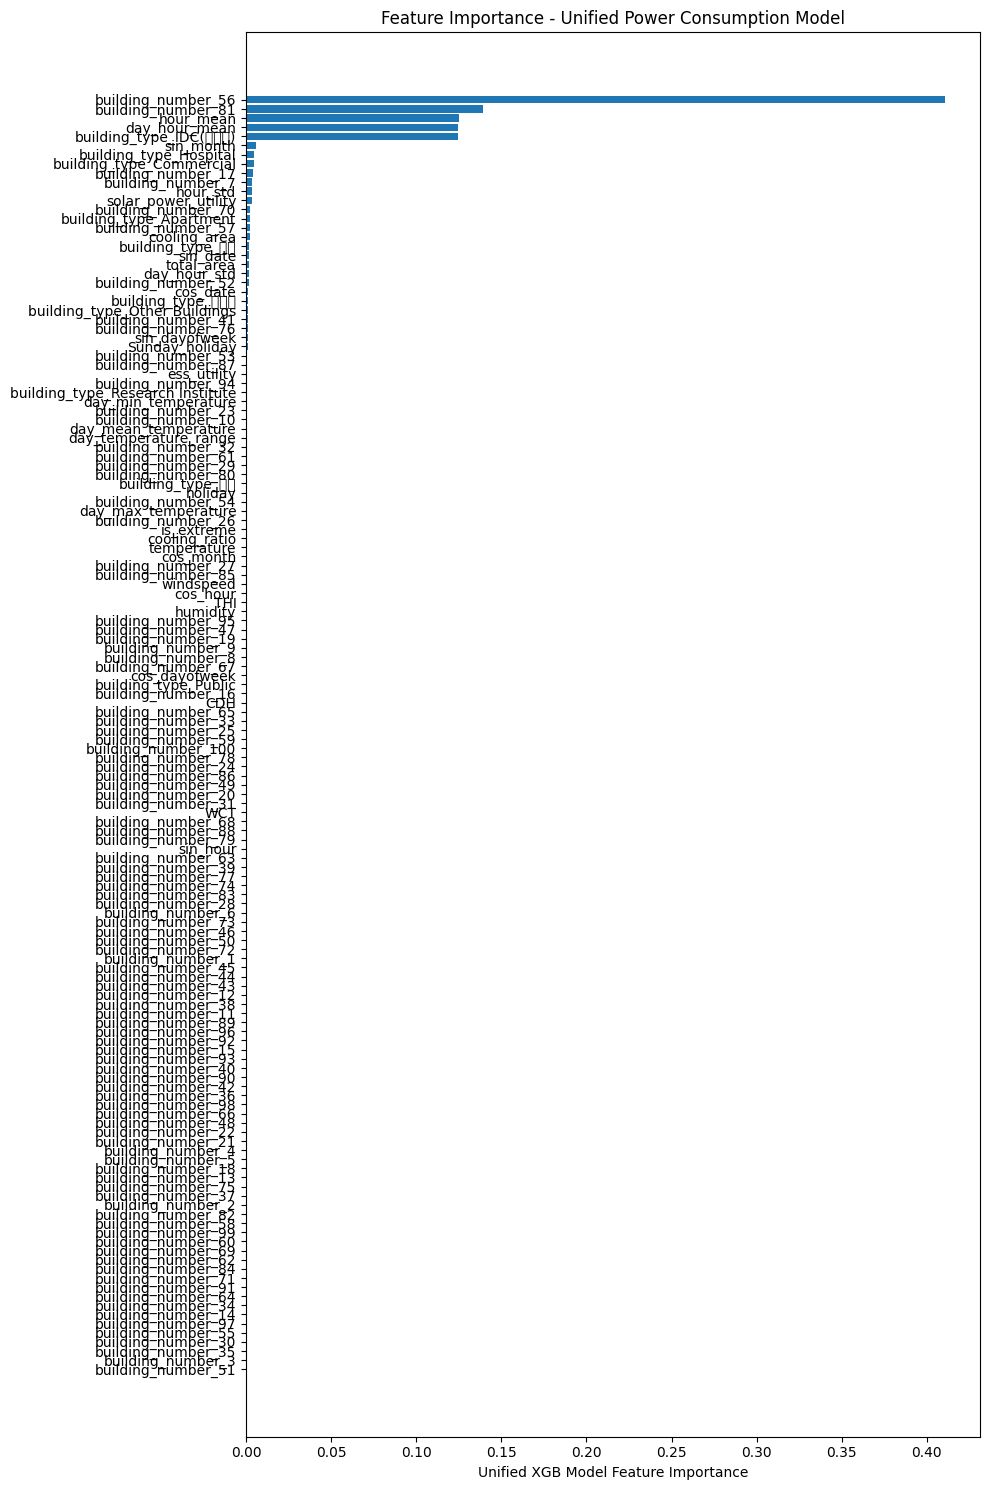


Unified XGBRegressor Model Results:
Average CV SMAPE: 3.5271
Fold SMAPE scores: ['3.5381', '3.5014', '3.5577', '3.5495', '3.4935', '3.5169', '3.5327']
Total OOF SMAPE: 3.5271


In [34]:
# K-Fold 설정
kf = KFold(n_splits=7, shuffle=True, random_state=RANDOM_SEED)
pred_df = pd.DataFrame(columns=['pred'])
xgb_model = None
# --- 통합 모델 데이터 준비 ---
x = X.copy()
y = Y['power_consumption'].astype(float).copy()
X_test_unified = test_X.copy()

# 라벨 클린업: NaN/Inf 제거 + 음수 방어
y = y.replace([np.inf, -np.inf], np.nan)
ok = y.notna() & (y >= 0)
if not ok.all():
    print(f"제거된 이상치/결측치: {(~ok).sum()}개")
    x = x.loc[ok]
    y = y.loc[ok]

# 원핫 인코딩 (building_type과 building_number 모두 포함)
categorical_columns = ['building_type', 'building_number']
x = pd.get_dummies(x, columns=categorical_columns, drop_first=False)
X_test_unified = pd.get_dummies(X_test_unified, columns=categorical_columns, drop_first=False)

# train/test 더미 컬럼 정렬/맞춤
x, X_test_unified = x.align(X_test_unified, join='outer', axis=1, fill_value=0)

# 피처 NaN/Inf 가드
x = x.replace([np.inf, -np.inf], np.nan).fillna(0)
X_test_unified = X_test_unified.replace([np.inf, -np.inf], np.nan).fillna(0)

# 이후 참조용 컬럼명
x_columns = np.array(x.columns)

# numpy 변환하지 말고 인덱스 보존: dtype만 정리
x = x.astype(np.float32)
y = y.astype(np.float32)

# 교차검증 변수 초기화
j = 0
xgb_fold_smape = []
answer_list = []

# OOF 그릇을 y의 원본 인덱스로 생성
pred = pd.DataFrame(index=y.index.copy(), columns=['pred'])

# 최적 하이퍼파라미터 설정 (전체 데이터용 - 예시값, 실제로는 하이퍼파라미터 튜닝 필요)
best_params = {
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'alpha': 1.0
}

print(f"전체 훈련 데이터 크기: {x.shape}")
print(f"전체 테스트 데이터 크기: {X_test_unified.shape}")

# K-Fold 교차검증
for train_index, valid_index in kf.split(x):
    j += 1
    print(f"\n=== Fold {j}/{kf.n_splits} ===")

    # iloc로 자르기: 인덱스/정렬 보존
    X_train, X_valid = x.iloc[train_index], x.iloc[valid_index]
    Y_train, Y_valid = y.iloc[train_index], y.iloc[valid_index]

    # log 대신 log1p로 -inf 방지 + 음수 차단
    Y_train_t = np.log1p(np.clip(Y_train, a_min=0, a_max=None))
    Y_valid_t = np.log1p(np.clip(Y_valid, a_min=0, a_max=None))

    # 안전 체크
    assert np.isfinite(Y_train_t).all() and np.isfinite(Y_valid_t).all()

    evals = [(X_train, Y_train_t), (X_valid, Y_valid_t)]

    # XGBoost 모델 설정
    xgb_model = XGBRegressor(
        learning_rate=0.05,
        n_estimators=5000,
        max_depth=int(best_params['max_depth']),
        random_state=RANDOM_SEED,
        subsample=best_params['subsample'],
        colsample_bytree=best_params['colsample_bytree'],
        min_child_weight=int(best_params['min_child_weight']),
        objective=weighted_mse(best_params['alpha']),
        tree_method='gpu_hist',
    )

    # 모델 훈련
    xgb_model.fit(
        X_train, Y_train_t,
        early_stopping_rounds=100,
        eval_metric=custom_smape,
        eval_set=evals,
        verbose=False
    )

    # 검증 예측 (역변환: expm1)
    xgb_pred_t = xgb_model.predict(X_valid)
    xgb_pred = np.expm1(xgb_pred_t)
    # 원본 인덱스로 기록
    pred.loc[Y_valid.index, 'pred'] = xgb_pred

    # SMAPE는 원스케일(y)에서 계산
    xgb_smape = smape(Y_valid.values, xgb_pred)
    xgb_fold_smape.append(xgb_smape)
    print(f'Fold {j} SMAPE: {xgb_smape:.4f}')

    # 테스트 예측 (expm1 역변환)
    xgb_answer_t = xgb_model.predict(X_test_unified)
    answer_list.append(np.expm1(xgb_answer_t))

    # 마지막 폴드에서 피처 중요도 그리기
    if j == kf.n_splits:
        sorted_idx = xgb_model.feature_importances_.argsort()
        plt.figure(figsize=(10, 15))
        plt.barh(x_columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
        plt.xlabel('Unified XGB Model Feature Importance')
        plt.title('Feature Importance - Unified Power Consumption Model')
        plt.tight_layout()
        plt.show()

# 전체 테스트 예측 평균
unified_answer = sum(answer_list) / len(answer_list)

# answer도 테스트 행 인덱스로 보존
answer = pd.DataFrame({'answer': unified_answer}, index=X_test_unified.index)

# 인덱스 유지한 채 concat
pred_df = pd.concat([pred_df, pred], axis=0)

# 평균 SMAPE 계산 및 출력
avg_smape = sum(xgb_fold_smape) / len(xgb_fold_smape)
print('\n' + '='*50)
print('Unified XGBRegressor Model Results:')
print(f'Average CV SMAPE: {avg_smape:.4f}')
print(f'Fold SMAPE scores: {[f"{score:.4f}" for score in xgb_fold_smape]}')

# Total SMAPE는 인덱스 맞춰 계산
total_score = smape(
    Y.loc[pred_df.index, 'power_consumption'].values.astype(float),
    pred_df['pred'].values.astype(float)
)
print(f'Total OOF SMAPE: {total_score:.4f}')
print('='*50)

In [40]:
print(np.expm1(xgb_model.predict(X_valid)), Y_valid)

[3668.373  4697.5244 5046.7173 ... 1516.2258 2110.1    2866.5085] 5         3367.590088
10        4494.720215
24        3870.419922
26        5689.169922
32        4359.180176
             ...     
201712    2162.639893
201723    2628.360107
201729    1319.400024
201735    1991.640015
201741    3197.520020
Name: power_consumption, Length: 28820, dtype: float32


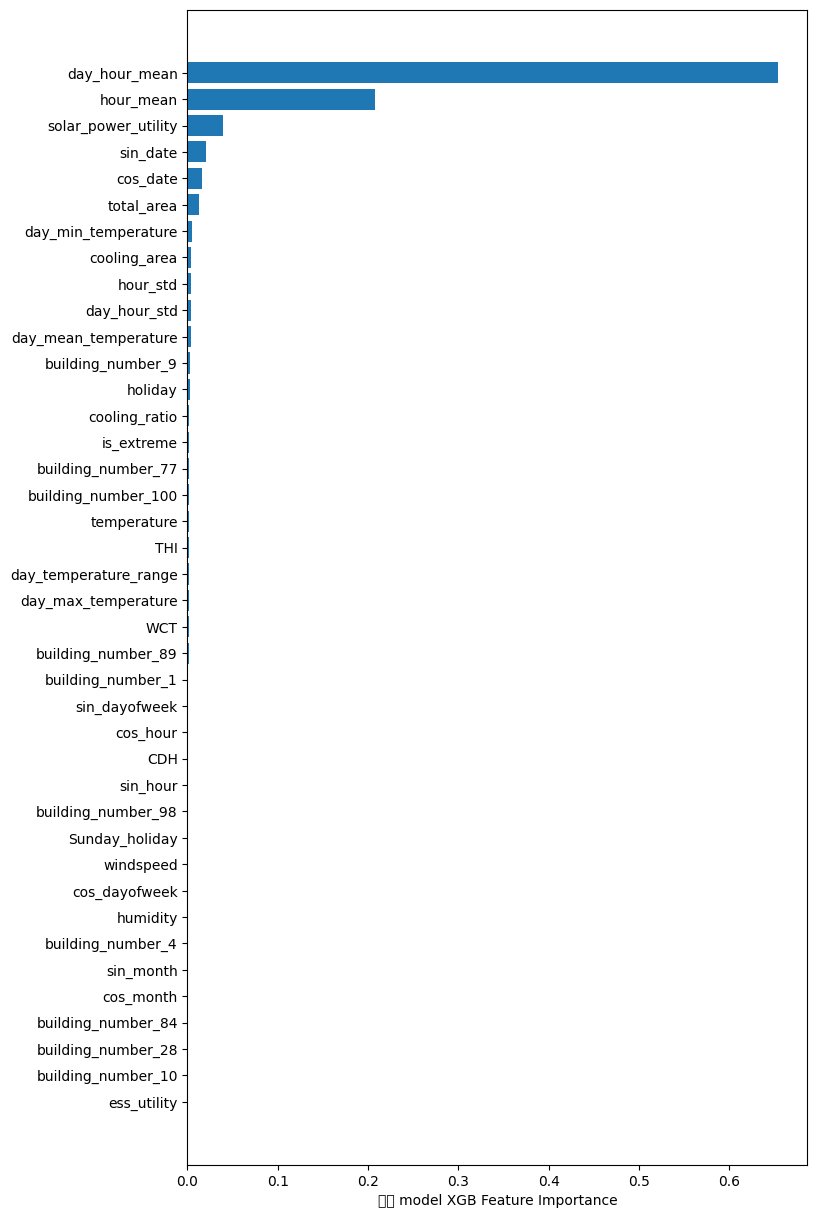

Building type = 호텔 : XGBRegressor Model SMAPE : 4.8013


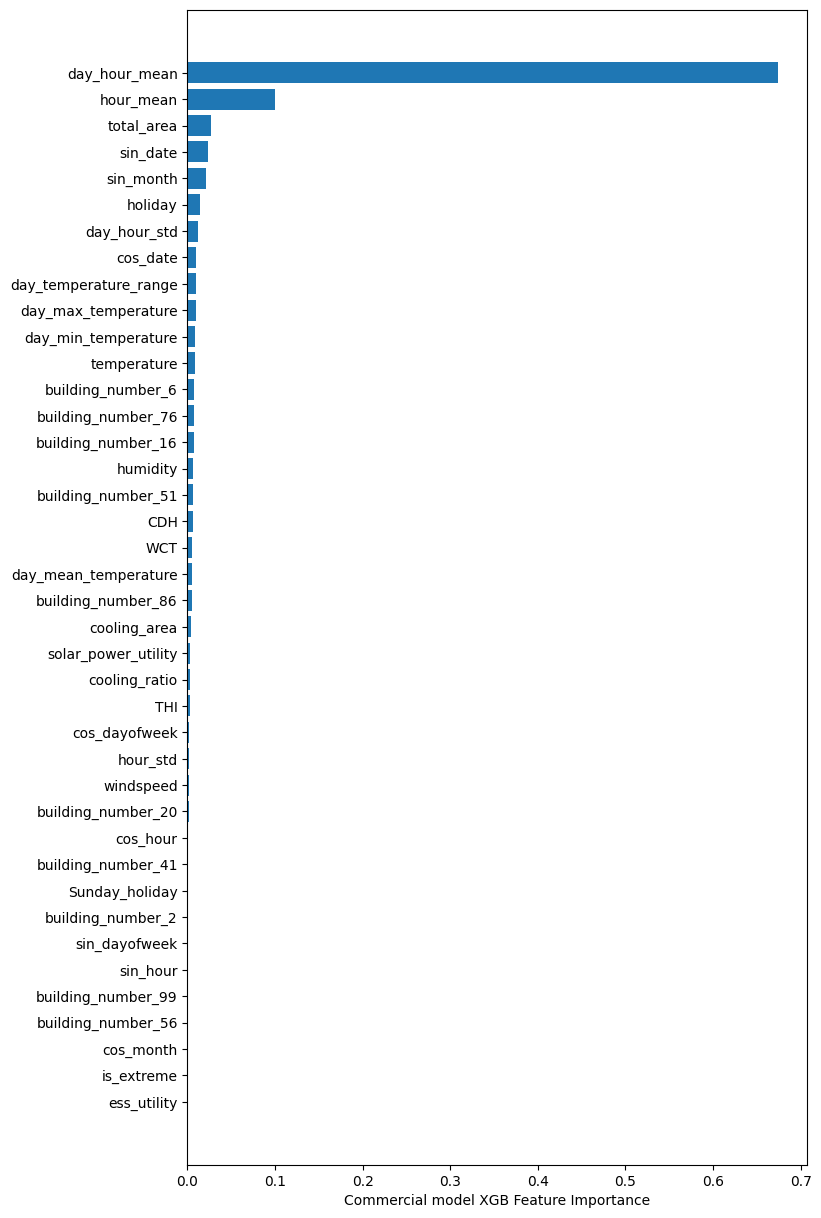

Building type = Commercial : XGBRegressor Model SMAPE : 2.2609


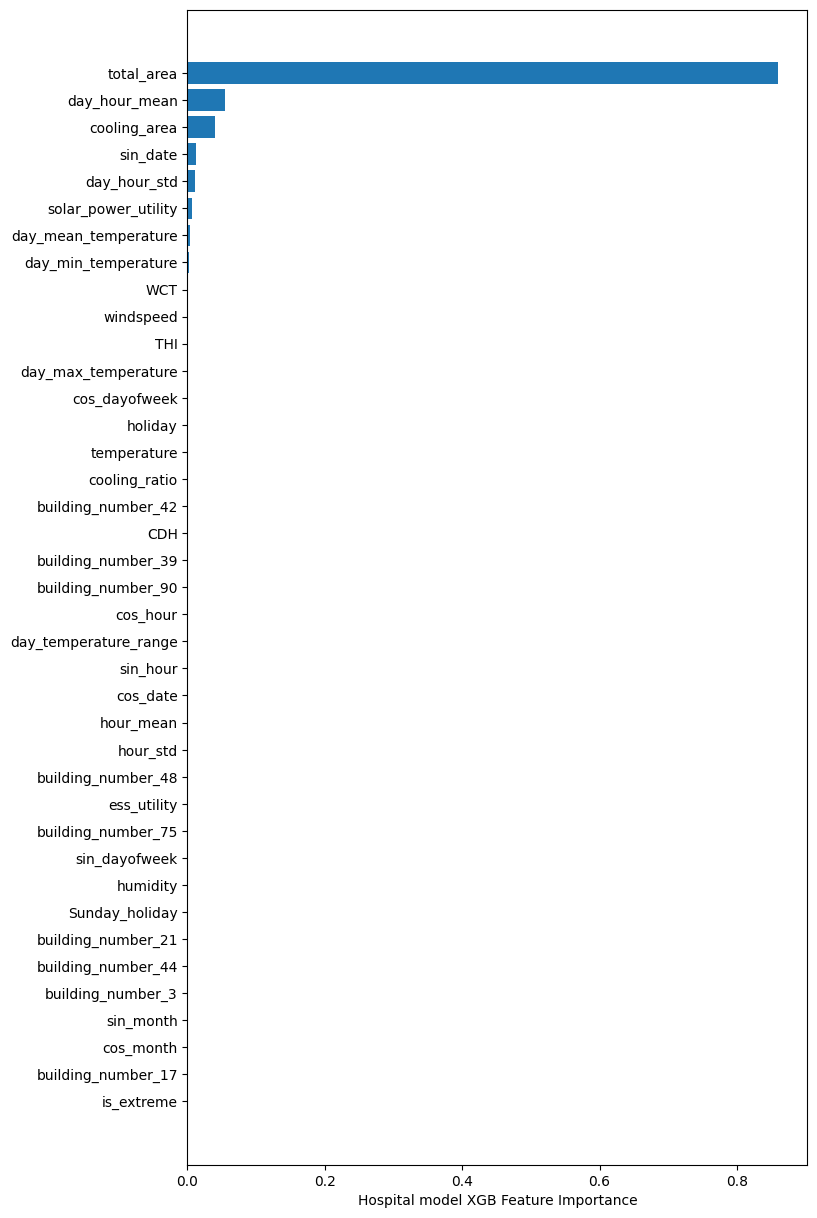

Building type = Hospital : XGBRegressor Model SMAPE : 2.7231


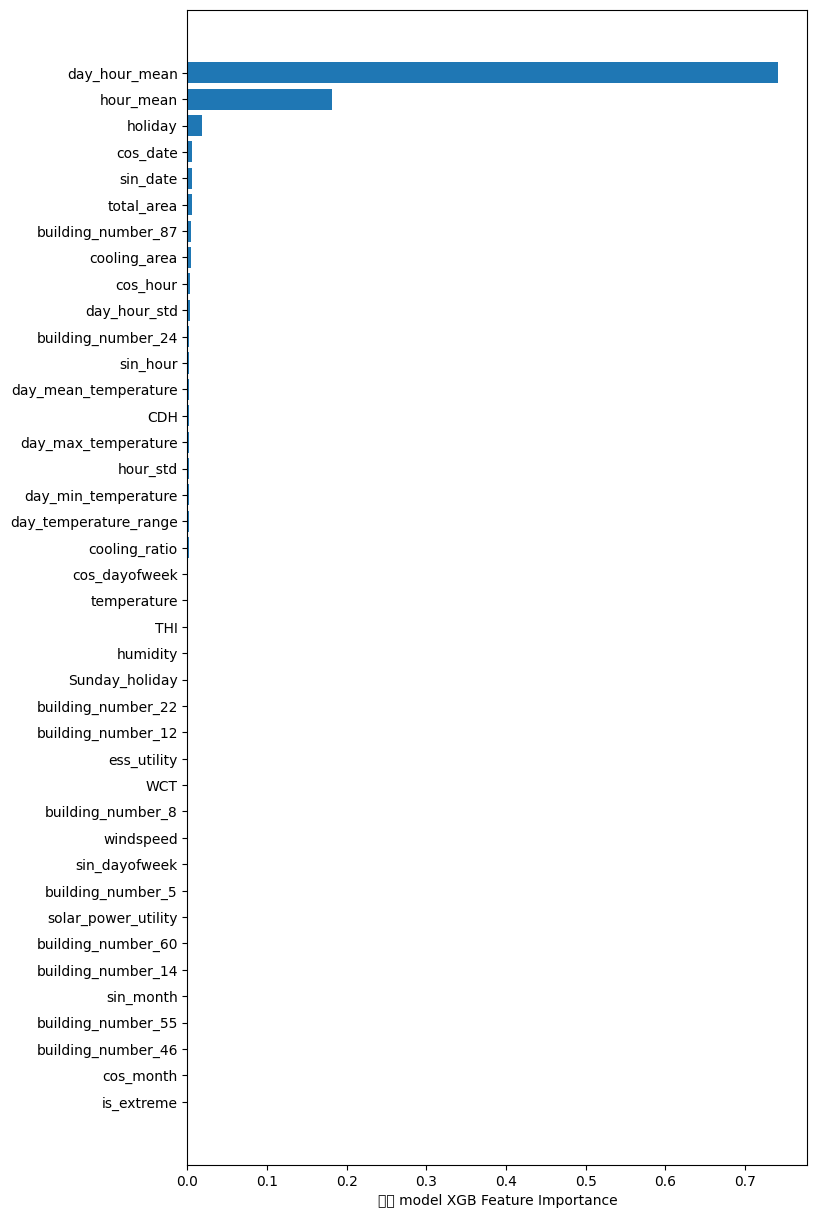

Building type = 학교 : XGBRegressor Model SMAPE : 2.6726


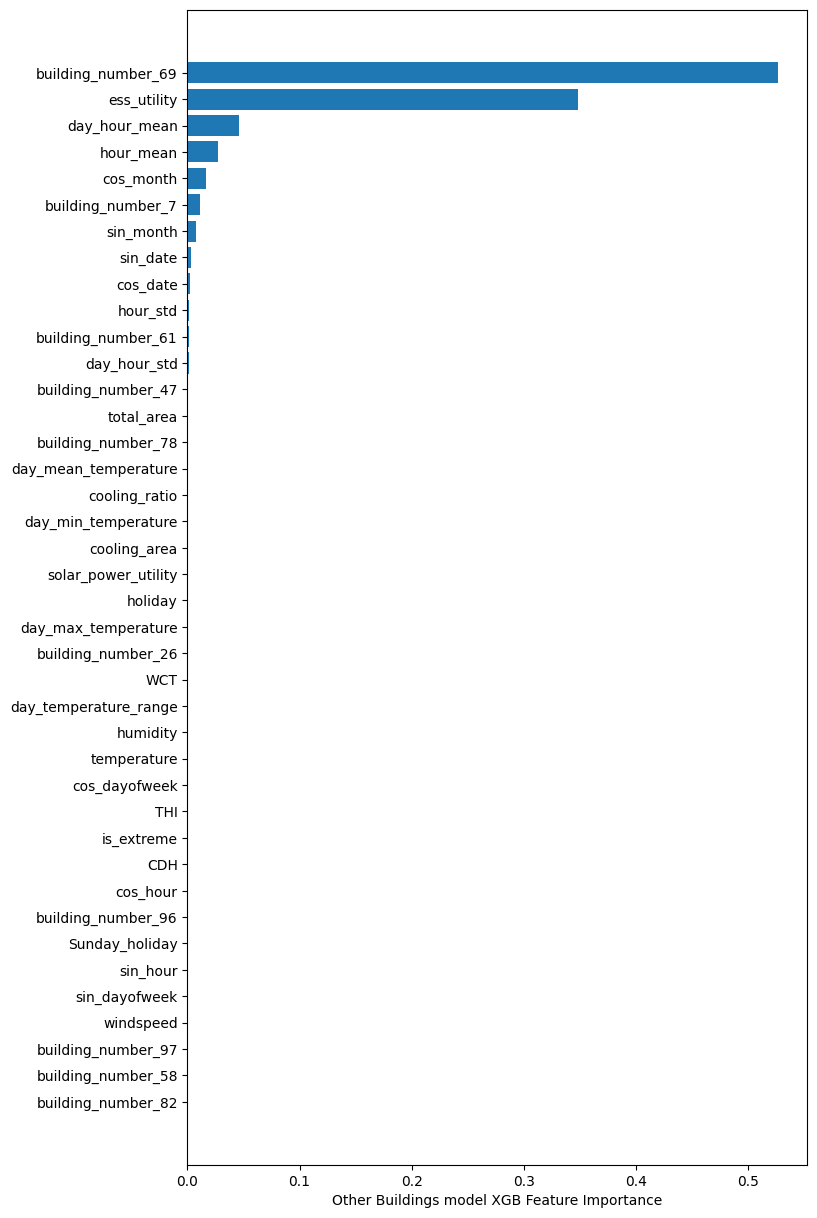

Building type = Other Buildings : XGBRegressor Model SMAPE : 4.7162


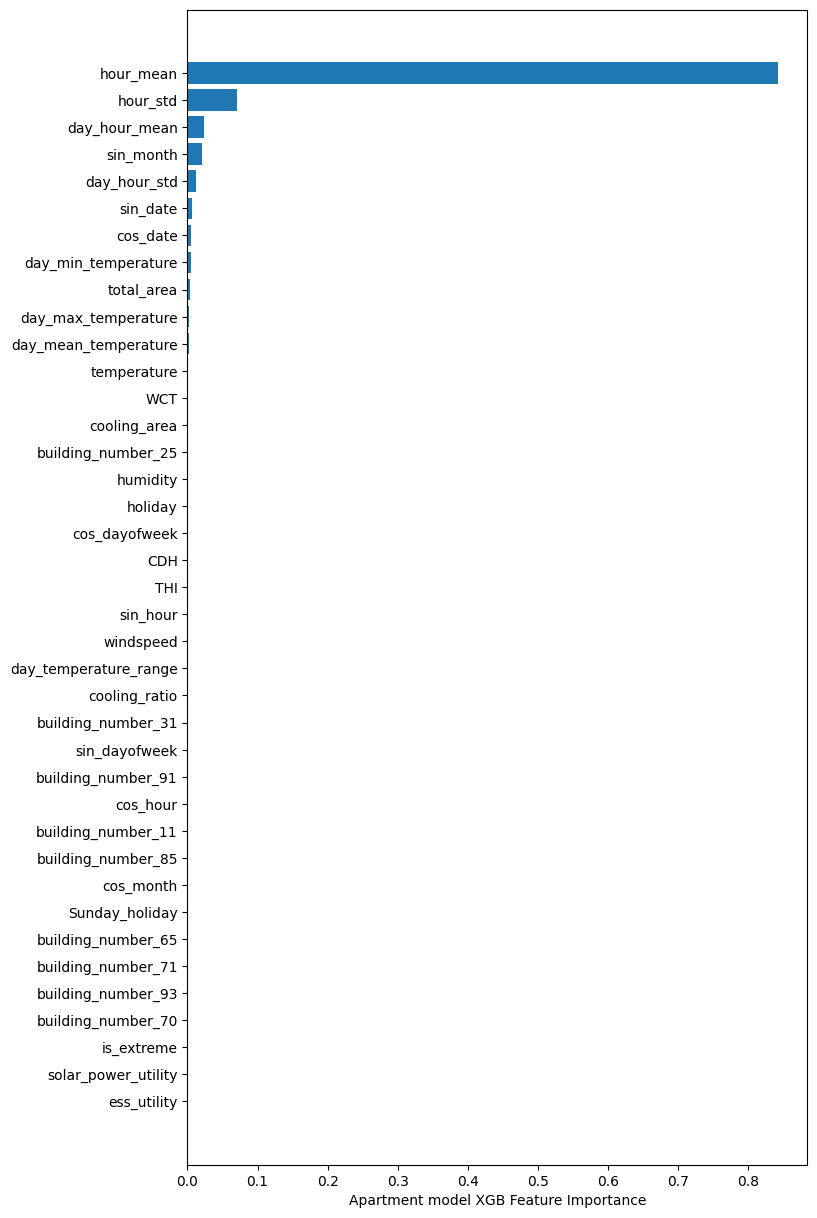

Building type = Apartment : XGBRegressor Model SMAPE : 3.2652


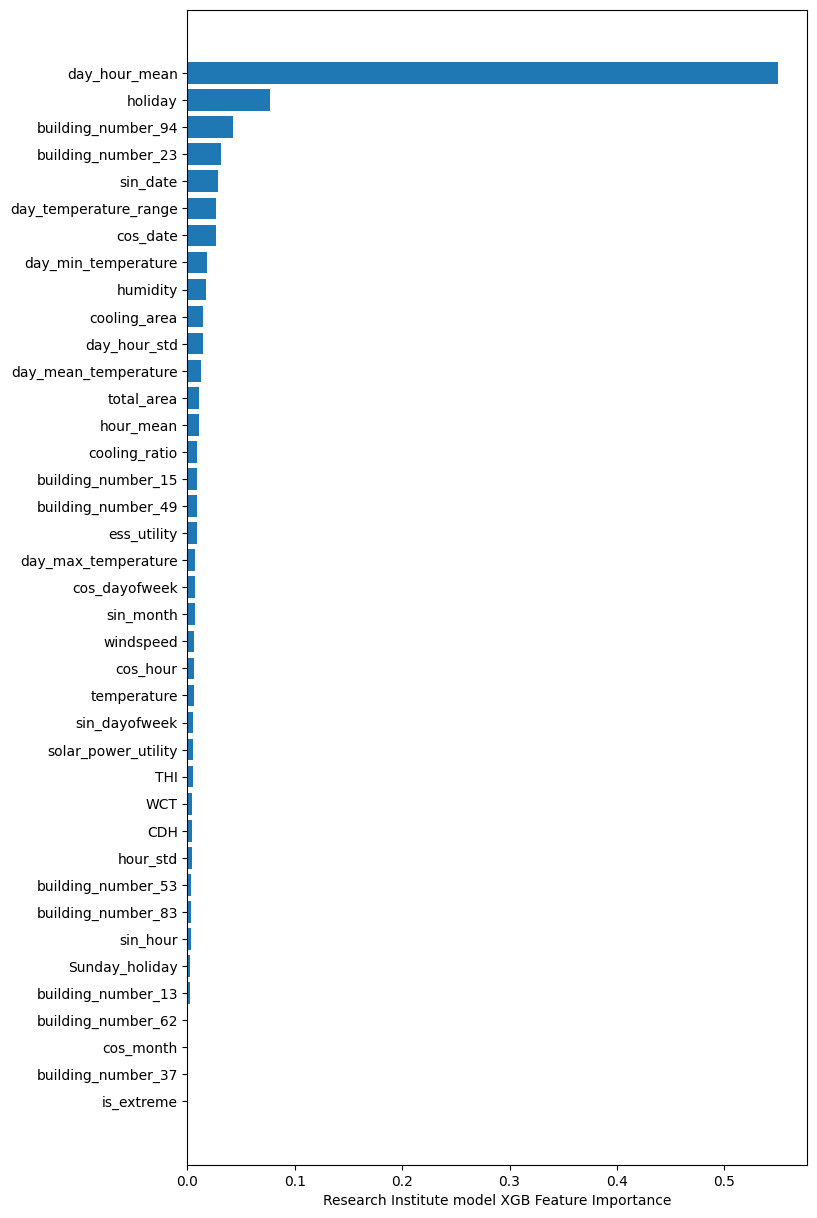

Building type = Research Institute : XGBRegressor Model SMAPE : 3.4984


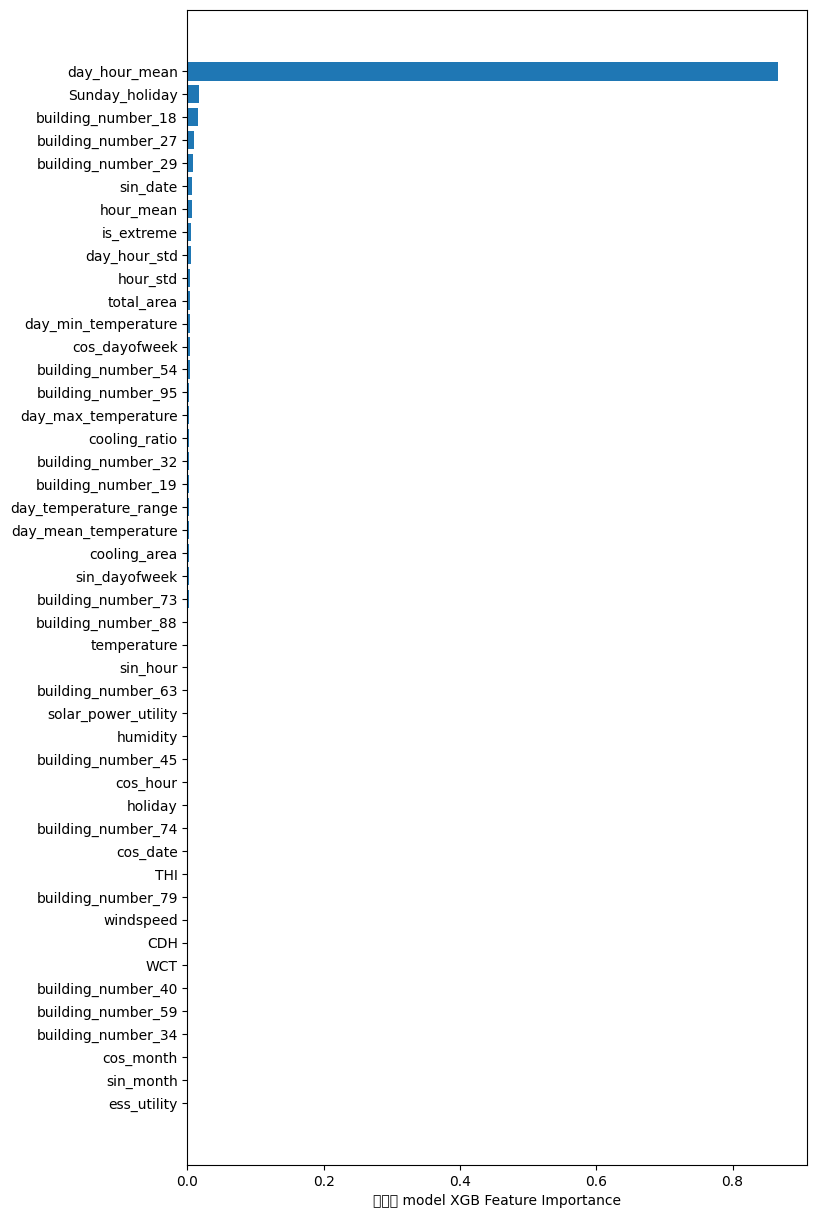

Building type = 백화점 : XGBRegressor Model SMAPE : 4.2594


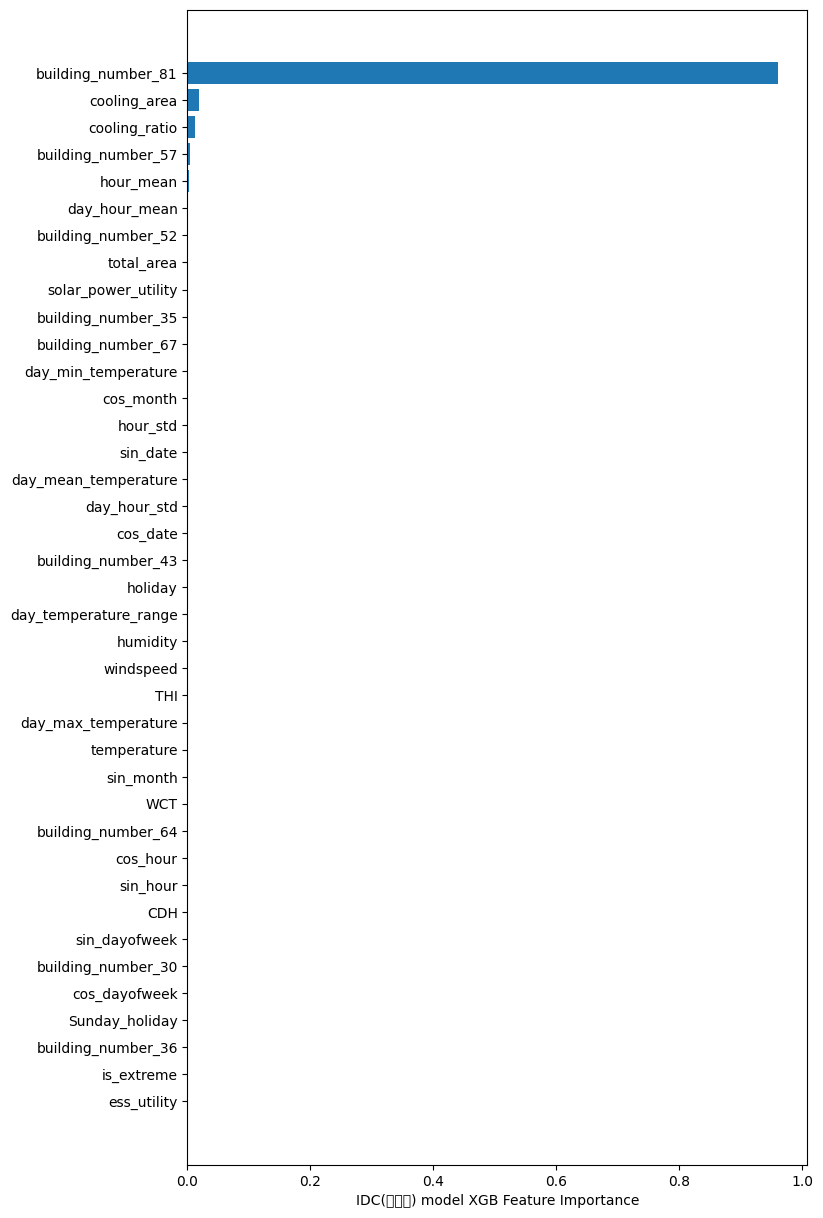

Building type = IDC(전화국) : XGBRegressor Model SMAPE : 0.9609


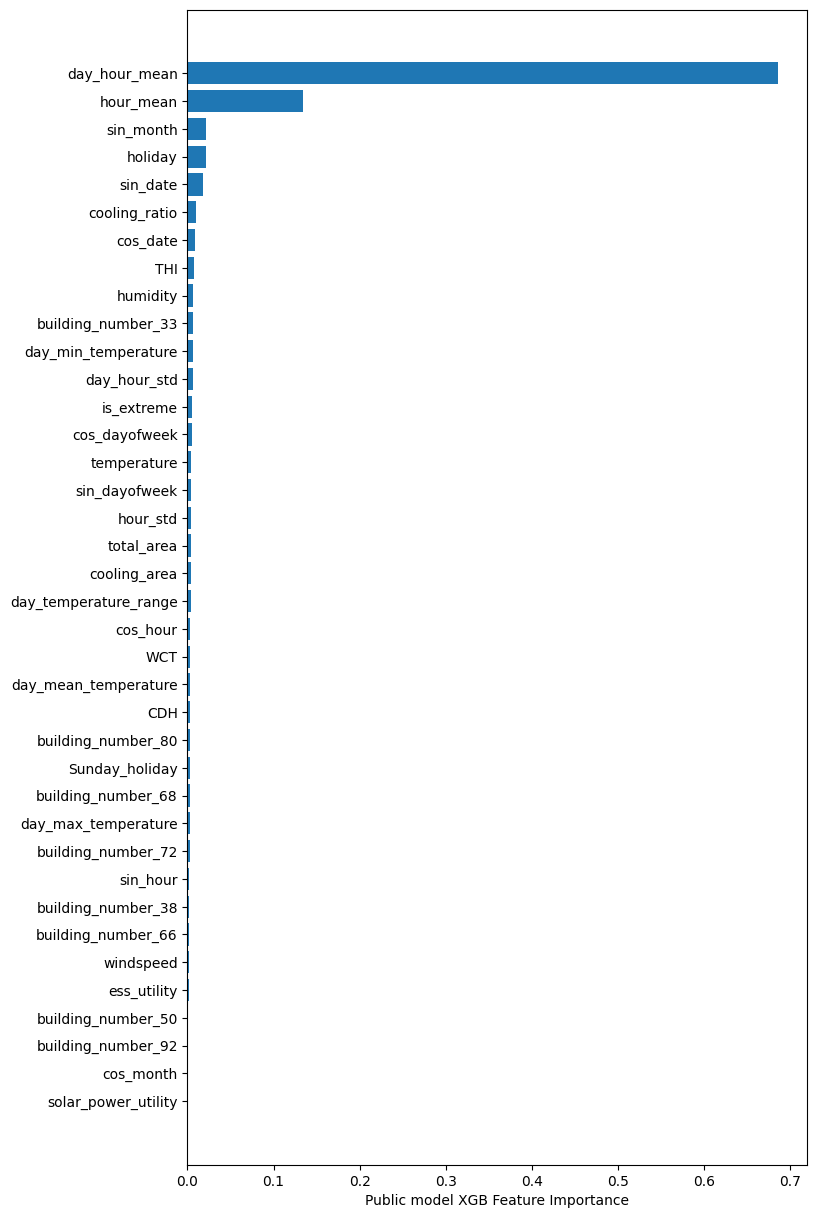

Building type = Public : XGBRegressor Model SMAPE : 4.8529
Total SMAPE : 3.4650


In [43]:
kf = KFold(n_splits=7, shuffle=True, random_state=RANDOM_SEED)
answer_df = pd.DataFrame(columns=['answer'])
pred_df   = pd.DataFrame(columns=['pred'])

for i in type_list:
    # --- 데이터 준비 ---
    x = X[X.building_type == i].copy()
    y = Y[Y.building_type == i]['power_consumption'].astype(float).copy()
    X_test_i = test_X[test_X.building_type == i].copy()

    # 라벨 클린업: NaN/Inf 제거 + 음수 방어
    y = y.replace([np.inf, -np.inf], np.nan)
    ok = y.notna() & (y >= 0)
    if not ok.all():
        x = x.loc[ok]
        y = y.loc[ok]

    # 원핫
    x = pd.get_dummies(x, columns=['building_number'], drop_first=False)
    X_test_i = pd.get_dummies(X_test_i, columns=['building_number'], drop_first=False)

    # 불필요 컬럼 제거 (있을 때만)
    for df_ in (x, X_test_i):
        if 'building_type' in df_.columns:
            df_.drop(columns=['building_type'], inplace=True)

    # (중요) train/test 더미 컬럼 정렬/맞춤
    x, X_test_i = x.align(X_test_i, join='outer', axis=1, fill_value=0)

    # 피처 NaN/Inf 가드
    x = x.replace([np.inf, -np.inf], np.nan).fillna(0)
    X_test_i = X_test_i.replace([np.inf, -np.inf], np.nan).fillna(0)

    # 이후 참조용 컬럼명
    x_columns = np.array(x.columns)

    # (중요) numpy 변환하지 말고 인덱스 보존: dtype만 정리
    x = x.astype(np.float32)
    y = y.astype(np.float32)

    j = 0
    xgb_fold_smape = []
    answer_list = []

    # (중요) OOF 그릇을 y의 '원본 인덱스'로 생성
    pred = pd.DataFrame(index=y.index.copy(), columns=['pred'])

    for train_index, valid_index in kf.split(x):
        j += 1

        # (중요) iloc로 자르기: 인덱스/정렬 보존
        X_train, X_valid = x.iloc[train_index], x.iloc[valid_index]
        Y_train, Y_valid = y.iloc[train_index], y.iloc[valid_index]

        # (중요) log 대신 log1p로 -inf 방지 + 음수 차단
        Y_train_t = np.log1p(np.clip(Y_train, a_min=0, a_max=None))
        Y_valid_t = np.log1p(np.clip(Y_valid, a_min=0, a_max=None))

        # 안전 체크
        assert np.isfinite(Y_train_t).all() and np.isfinite(Y_valid_t).all()

        evals = [(X_train, Y_train_t), (X_valid, Y_valid_t)]

        split_xgb_model = XGBRegressor(
            learning_rate=0.05,
            n_estimators=5000,
            max_depth=int(xgb_best_params.loc[i]['max_depth']),
            random_state=RANDOM_SEED,
            subsample=xgb_best_params.loc[i]['subsample'],
            colsample_bytree=xgb_best_params.loc[i]['colsample_bytree'],
            min_child_weight=int(xgb_best_params.loc[i]['min_child_weight']),
            objective=weighted_mse(xgb_best_params.loc[i]['alpha']),
            tree_method='gpu_hist',
        )

        split_xgb_model.fit(
            X_train, Y_train_t,
            early_stopping_rounds=100,
            eval_metric=custom_smape,   # 기존 유지
            eval_set=evals,
            verbose=False
        )

        # 검증 예측 (역변환: expm1)
        xgb_pred_t = split_xgb_model.predict(X_valid)
        xgb_pred = np.expm1(xgb_pred_t)
        # (중요) 원본 인덱스로 기록
        pred.loc[Y_valid.index, 'pred'] = xgb_pred

        # SMAPE는 원스케일(y)에서 계산
        xgb_smape = smape(Y_valid.values, xgb_pred)
        xgb_fold_smape.append(xgb_smape)

        # 테스트 예측 (expm1 역변환)
        xgb_answer_t = split_xgb_model.predict(X_test_i)
        answer_list.append(np.expm1(xgb_answer_t))

        # 마지막 폴드에서 중요도 그리기
        if j == kf.n_splits:
            sorted_idx = split_xgb_model.feature_importances_.argsort()
            plt.figure(figsize=(8, 15))
            plt.barh(x_columns[sorted_idx], split_xgb_model.feature_importances_[sorted_idx])
            plt.xlabel(f'{i} model XGB Feature Importance')
            plt.show()

    pred_df   = pd.concat([pred_df, pred], axis=0)

    avg_smape = sum(xgb_fold_smape) / len(xgb_fold_smape)
    print('Building type = %s : XGBRegressor Model SMAPE : %.4f' % (i, avg_smape))
    if avg_smape >= 4.0:
      # 타입별 테스트 평균
      answer = sum(answer_list) / len(answer_list)
      total_answer = np.expm1(xgb_model.predict(X_test_unified.loc[X_test_i.index]))
      type_answer = (total_answer + answer)/2

    else:
      type_answer = sum(answer_list) / len(answer_list)

    # (중요) answer도 테스트 행 인덱스로 보존
    answer = pd.DataFrame({'answer': type_answer}, index=X_test_i.index)
    # (중요) 인덱스 유지한 채 concat (ignore_index 금지)
    answer_df = pd.concat([answer_df, answer], axis=0)

# (중요) Total SMAPE는 인덱스 맞춰 계산
total_score = smape(
    Y.loc[pred_df.index, 'power_consumption'].values.astype(float),
    pred_df['pred'].values.astype(float)
)
print('Total SMAPE : %.4f' % (total_score))

## 정답파일 만들기

In [44]:
answer = pd.read_csv('sample_submission.csv')

In [45]:
answer.answer = answer_df.answer

In [46]:
answer.to_csv('submission.csv',index = False)

In [47]:
answer.head()

,num_date_time,answer
0,1_20240825 00,4244.489258
1,1_20240825 01,4483.765625
2,1_20240825 02,3693.258301
3,1_20240825 03,3397.123779
4,1_20240825 04,3182.259766
